In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Dataset shape: (1599, 12)
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8      

<Figure size 800x600 with 0 Axes>

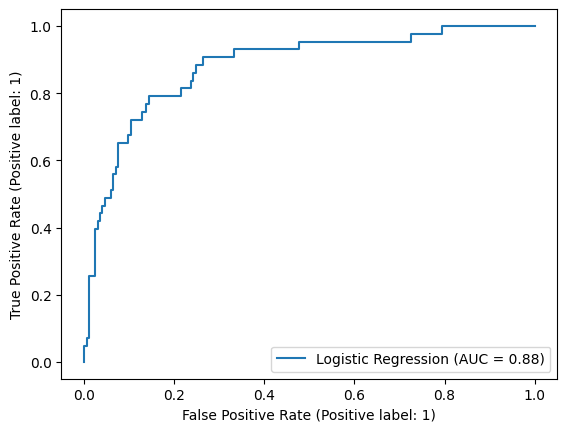

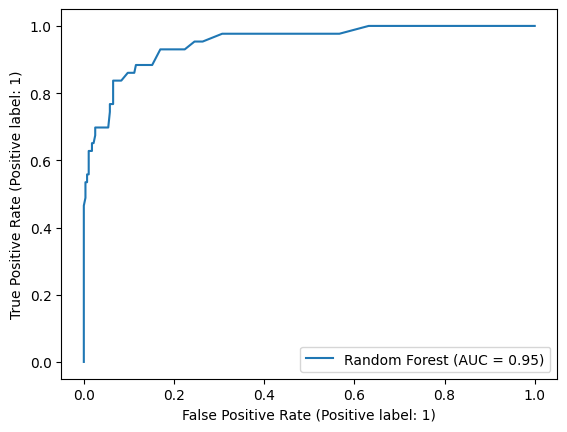

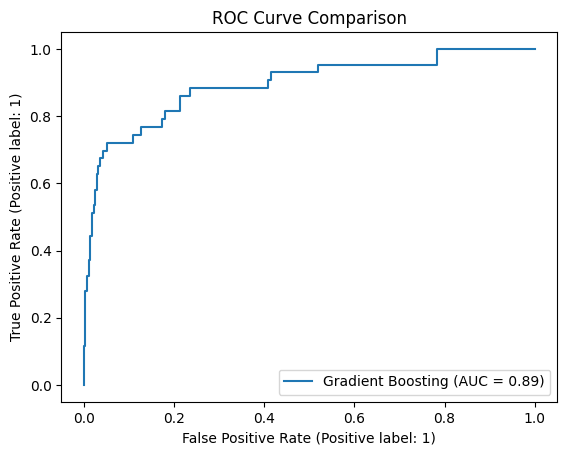

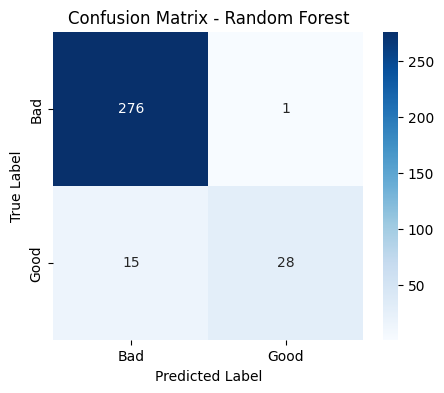


Performance Summary (Classification):


,Precision (Good),Recall (Good),ROC AUC
Logistic Regression,0.695652,0.372093,0.880279
Random Forest,0.965517,0.651163,0.947192
Gradient Boosting,0.785714,0.511628,0.891865


In [2]:
# ===============================
# Wine Quality Prediction - Regression & Classification
# ===============================

# 1. Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    mean_squared_error, r2_score, classification_report,
    confusion_matrix, roc_auc_score, RocCurveDisplay
)

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier

# 2. Load Dataset
# Use winequality-red.csv or winequality-white.csv
df = pd.read_csv("/kaggle/input/red-wine-quality-cortez-et-al-2009/winequality-red.csv")  # change path if needed

print("Dataset shape:", df.shape)
print(df.head())

# 3. Split Features and Target
X = df.drop("quality", axis=1)
y = df["quality"]

# For classification: good wine (quality >= 7), bad otherwise
y_class = (y >= 7).astype(int)

# 4. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X, y_class, test_size=0.2, random_state=42, stratify=y_class
)

# ========================
# REGRESSION
# ========================
regressors = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(),
}

print("\n===== REGRESSION TASK =====")
for name, model in regressors.items():
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('reg', model)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    print(f"\n{name}")
    print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
    print("R2 Score:", r2_score(y_test, y_pred))

# ========================
# CLASSIFICATION
# ========================
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=5000),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
}

results = {}
print("\n===== CLASSIFICATION TASK =====")
for name, model in classifiers.items():
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', model)
    ])
    pipe.fit(X_train_c, y_train_c)
    y_pred = pipe.predict(X_test_c)
    y_prob = pipe.predict_proba(X_test_c)[:, 1]
    
    results[name] = {
        "report": classification_report(y_test_c, y_pred, output_dict=True),
        "roc_auc": roc_auc_score(y_test_c, y_prob),
        "conf_matrix": confusion_matrix(y_test_c, y_pred)
    }
    print(f"\n{name}")
    print(classification_report(y_test_c, y_pred))
    print("ROC AUC:", roc_auc_score(y_test_c, y_prob))

# 5. ROC Curves
plt.figure(figsize=(8,6))
for name, model in classifiers.items():
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', model)
    ])
    pipe.fit(X_train_c, y_train_c)
    RocCurveDisplay.from_estimator(pipe, X_test_c, y_test_c, name=name)
plt.title("ROC Curve Comparison")
plt.show()

# 6. Confusion Matrix for Best Classifier (Random Forest as example)
best_model = "Random Forest"
cm = results[best_model]["conf_matrix"]

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Bad", "Good"], yticklabels=["Bad", "Good"])
plt.title(f"Confusion Matrix - {best_model}")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# 7. Summary Table
summary = pd.DataFrame({
    model: {
        "Precision (Good)": results[model]["report"]["1"]["precision"],
        "Recall (Good)": results[model]["report"]["1"]["recall"],
        "ROC AUC": results[model]["roc_auc"]
    }
    for model in results
}).T

print("\nPerformance Summary (Classification):")
display(summary)
